# Conceptos básicos de Spark Streaming

## Objetivos de Aprendizaje
Al final de esta lección, debería ser capaz de:

* Describir el modelo de programación utilizado por Spark Structured Streaming
* Configure las opciones requeridas para realizar una lectura de streaming de una fuente
* Describir los requisitos para la tolerancia a fallas de extremo a extremo
* Configure las opciones requeridas para realizar una escritura de streaming en un sumidero
* Interactuar con consultas en streaming y detener streams activas

## Dataset Utilizado
La fuente contiene muestras de acelerómetros de teléfonos inteligentes de dispositivos y usuarios con las siguientes columnas:

| Field          | Description |
| ------------- | ----------- |
| Arrival_Time | time data was received |
| Creation_Time | event time |
| Device | type of Model |
| Index | unique identifier of event |
| Model | i.e Nexus4  |
| User | unique user identifier |
| geolocation | city & country |
| gt | transportation mode |
| id | unused null field |
| x | acceleration in x-dir |
| y | acceleration in y-dir |
| z | acceleration in z-dir |

## Inicio

Ejecutar la siguiente celda para configurar nuestra clase

In [0]:
%run ./Includes/classic-setup $mode="reset"


username: gonzalo.delgado.r@uni.pe
userhome: dbfs:/user/gonzalo.delgado.r@uni.pe/sslh
database: sslh_gonzalo_delgado_r_uni_pe_db


Mounting course-specific datasets to /mnt/training ... Datasets are already mounted to /mnt/training .

-sandbox

## Micro-lotes como Tabla

Para obtener más información, consulte la sección análoga en la [Guía de programación de streaming estructurada](http://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#basic-concepts) (de la que se han tomado prestadas varias imágenes).

Spark Structured Streaming se acerca a la transmisión de datos al modelarlos como una serie de anexos continuos a una tabla ilimitada. Si bien es similar a definir la lógica de microlotes, este modelo permite definir consultas incrementales en fuentes de transmisión como si fueran entradas estáticas.


<img src="http://spark.apache.org/docs/latest/img/structured-streaming-stream-as-a-table.png" style="height: 300px"/>

### Conceptos Básicos

- El desarrollador define una **tabla de entrada** configurando una lectura de transmisión contra una **fuente**. La sintaxis proporciona una entrada que es casi análoga a trabajar con datos estáticos.
- Una **consulta** se define en la tabla de entrada. Tanto la API de DataFrames como Spark SQL se pueden usar para definir fácilmente transformaciones y acciones en la tabla de entrada.
- Esta consulta lógica en la tabla de entrada genera la **tabla de resultados**. La tabla de resultados contiene la información de estado incremental de la secuencia.
- La **salida** de una canalización de transmisión mantendrá las actualizaciones en la tabla de resultados al escribir en un receptor externo. Por lo general, un sumidero será un sistema duradero, como archivos o un bus de mensajería pub/sub.
- Se agregan nuevas filas a la tabla de entrada para cada **intervalo de activación**. Estas nuevas filas son esencialmente análogas a las transacciones de microlotes y se propagarán automáticamente a través de la tabla de resultados al sumidero.


<img src="http://spark.apache.org/docs/latest/img/structured-streaming-model.png" style="height: 300px"/>

Esta lección demostrará la facilidad de adaptar la lógica por lotes a la transmisión de datos para ejecutar cargas de trabajo de datos casi en tiempo real.

## End-to-end Tolerancia a Fallos

La transmisión estructurada garantiza garantías de tolerancia a fallas exactamente una vez de extremo a extremo a través de puntos de control (discutidos a continuación) y 
<a href="https://en.wikipedia.org/wiki/Write-ahead_logging" target="_blank">registros de escritura anticipada.</a>

Las fuentes de transmisión estructurada, los receptores y el motor de ejecución subyacente trabajan juntos para rastrear el progreso del procesamiento de la transmisión. Si ocurre una falla, el motor de transmisión intenta reiniciar y/o reprocesar los datos. Para conocer las prácticas recomendadas sobre la recuperación de una consulta de transmisión fallida, consulte los <a href="">documentos</a>.

Este enfoque solo funciona si la fuente de transmisión se puede reproducir; las fuentes reproducibles incluyen almacenamiento de objetos basado en la nube y servicios de mensajería pub/sub.

En un nivel alto, el mecanismo de transmisión subyacente se basa en un par de enfoques:

* En primer lugar, la transmisión estructurada utiliza puntos de control y registros de escritura anticipada para registrar el rango de compensación de los datos que se procesan durante cada intervalo de activación.
* A continuación, los sumideros de transmisión están diseñados para ser idempotentes, es decir, varias escrituras de los mismos datos (identificados por el desplazamiento) no dan como resultado que se escriban duplicados en el sumidero.

En conjunto, las fuentes de datos reproducibles y los sumideros idempotentes permiten que la transmisión estructurada garantice **una semántica de extremo a extremo y exactamente una vez** en cualquier condición de falla.

## Lectura de Stream

El método `readStream` devuelve un `DataStreamReader` que se usa para configurar la transmisión.

La configuración de una lectura de transmisión en una fuente requiere:
* El esquema de los datos.
* El `format` de la fuente [(formato de archivo o conector con nombre)](https://docs.microsoft.com/en-us/azure/databricks/spark/latest/structured-streaming/data-sources)
* Configuraciones específicas de la fuente:
  * [Kafka](https://docs.databricks.com/spark/latest/structured-streaming/kafka.html)
  * [Centros de eventos](https://docs.databricks.com/spark/latest/structured-streaming/streaming-event-hubs.html)

## El Esquema
Cada DataFrame de transmisión debe tener un esquema. Al conectarse a sistemas pub/sub como Kafka y Event Hubs, la fuente proporcionará automáticamente el esquema.

Para otras fuentes de transmisión, el esquema debe estar definido por el usuario. No es seguro deducir el esquema de los archivos, ya que se supone que la fuente crece indefinidamente desde cero registros.

In [0]:
schema = "Arrival_Time BIGINT, Creation_Time BIGINT, Device STRING, Index BIGINT, Model STRING, User STRING, geolocation STRUCT<city: STRING, country: STRING>, gt STRING, id BIGINT, x DOUBLE, y DOUBLE, z DOUBLE"

-sandbox
### Diferencias entre lecturas estáticas y de transmisión

En la celda a continuación, se muestra una lectura estática y una de transmisión para lo cual se definen la misma fuente (archivos en un directorio en un almacén de objetos en la nube). Tenga en cuenta que la sintaxis es idéntica excepto que la consulta de transmisión usa `readStream` en lugar de `read`.

<img alt="Side Note" width="25.0em" title="Side Note" style="vertical-align: text-bottom; position: relative; top:0.05em; transform:rotate(15deg)" src="https://files.training.databricks.com/static/images/icon-note.webp"/> Si bien `maxFilesPerTrigger` se usará en todo el material de este curso para limitar la rapidez con la que se consumen los archivos de origen, esto es opcional y tiene fines de demostración. Esta opción permite controlar la cantidad de datos que se procesarán en cada microlote.

In [ ]:
dataPath = "/mnt/training/definitive-guide/data/activity-json/streaming"

# lectura batch
staticDF = (spark
  .read
  .format("json")
  .schema(schema)
  .load(dataPath)
)

# Lectura Streaming
streamingDF = (spark
  .readStream
  .format("json")
  .schema(schema)
  .option("maxFilesPerTrigger", 1)     # Opcional; fuerza el procesamiento de un solo archivo por suceso 
  .load(dataPath)
)

Al igual que con los marcos de datos estáticos, los datos no se procesan y los trabajos no se activan hasta que se llama a una acción.

## Escribiendo en Streaming
El método `DataFrame.writeStream` devuelve un `DataStreamWriter` que se usa para configurar la salida de la transmisión.

Hay una serie de parámetros necesarios para configurar una escritura de transmisión:
* El `format` del **sumidero de salida** (ver [documentación](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#output-sinks))
* La ubicación del **directorio de puntos de control**.
* El **modo de salida**
* Configuraciones específicas del sumidero de salida, como:
  * [Kafka](https://docs.databricks.com/spark/latest/structured-streaming/kafka.html)
  * [Centros de eventos](https://docs.databricks.com/spark/latest/structured-streaming/streaming-event-hubs.html)
  * Un <a href="https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=foreach#pyspark.sql.streaming.DataStreamWriter.foreach"target="_blank">sumidero personalizado</a> a través de `writeStream.foreach(...)`

Una vez completada la configuración, active el trabajo con una llamada a .start(). Al escribir en archivos, use .start(filePath).

### Checkpointing
Databricks crea puntos de control al almacenar el estado actual de su trabajo de transmisión en Azure Blob Storage o ADLS.

Los puntos de control se combinan con los registros de escritura anticipada para permitir que una transmisión terminada se reinicie y continúe desde donde se quedó.

Los puntos de control no se pueden compartir entre secuencias separadas.

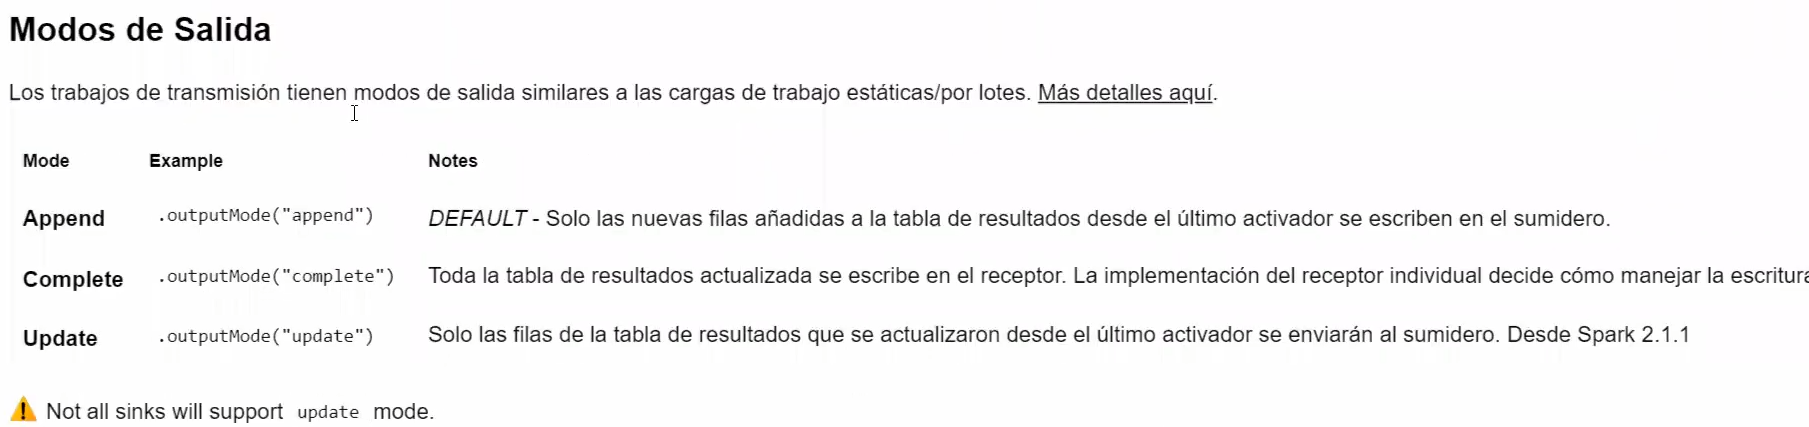

## Diferencias entre escrituras estáticas y de transmisión

La siguiente celda muestra la lógica por lotes para agregar datos de una lectura estática.

In [0]:
# Forma normal
outputPath = userhome + "/static-write"

dbutils.fs.rm(outputPath, True)    # clear this directory in case lesson has been run previously

# Escritura Batch
(staticDF                                
  .write                                               
  .format("delta")            #delta es tipo de archivo especial para databricks es como una especie de parquet                              
  .mode("append")                                       
  .save(outputPath))

Tenga en cuenta que solo hay pequeñas diferencias de sintaxis al escribir una transmisión en su lugar:

- `writeStream` en lugar de `write`
- La ruta para el punto de control se proporciona a la opción `checkpointLocation`
- `outputMode` en lugar de `mode` (tenga en cuenta que la transmisión usa `complete` en lugar de `overwrite` para una funcionalidad similar aquí)
- `start` en lugar de `save`

La siguiente celda muestra una escritura de transmisión en archivos Delta.

Nota: Asignar un nombre de variable al escribir en un receptor proporciona acceso programático a un objeto `StreamingQuery`. Esto será discutido abajo.

In [ ]:
# Forma Streaming
outputPath = userhome + "/streaming-concepts"
checkpointPath = outputPath + "/checkpoint"

dbutils.fs.rm(outputPath, True)    # clear this directory in case lesson has been run previously

# Escritura Streaming
streamingQuery = (streamingDF                                
  .writeStream                      # podria ser en forma parquet                          
  .format("delta")                                          
  .option("checkpointLocation", checkpointPath)   #puntos de control por si algo falla            
  .outputMode("append")
#   .queryName("my_stream")        # optional argument to register stream to Spark catalog
  .start(outputPath)                                       
)

## Streaming con Delta Lake

En la lógica definida anteriormente, los datos se leen de archivos JSON y luego se guardan en el formato Delta Lake. Tenga en cuenta que debido a que Delta crea una nueva versión para cada transacción, cuando se trabaja con transmisión de datos, esto significa que la tabla Delta crea una nueva versión para cada intervalo de activación en el que se procesan nuevos datos. [Más información sobre la transmisión con Delta](https://docs.databricks.com/delta/delta-streaming.html#table-streaming-reads-and-writes).

## Definiciendo el intervalo del Trigger

Al definir una escritura de transmisión, el método `trigger` especifica cuándo el sistema debe procesar el siguiente conjunto de datos. El ejemplo anterior usa el valor predeterminado, que es lo mismo que `.trigger(Trigger.ProcessingTime("500 ms"))`.


| Trigger Type                           | Example | Notes |
|----------------------------------------|-----------|-------------|
| Unspecified                            |  | _DEFAULT_ - The query will be executed as soon as the system has completed processing the previous query |
| Fixed interval micro-batches           | `.trigger(Trigger.ProcessingTime("2 minutes"))` | The query will be executed in micro-batches and kicked off at the user-specified intervals |
| One-time micro-batch                   | `.trigger(Trigger.Once())` | The query will execute _only one_ micro-batch to process all the available data and then stop on its own |
| Continuous w/fixed checkpoint interval | `.trigger(Trigger.Continuous("1 second"))` | The query will be executed in a low-latency, <a href="http://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#continuous-processing" target = "_blank">continuous processing mode</a>. _EXPERIMENTAL_ in 2.3.2 |

Tenga en cuenta que los activadores se especifican al definir cómo se escribirán los datos en un sumidero y controlar la frecuencia de los microlotes. De manera predeterminada, Spark detectará y procesará automáticamente todos los datos en la fuente que se agregaron desde el último desencadenante; algunas fuentes permiten la configuración para limitar el tamaño de cada microlote.


:BEST_PRACTICE: Lea [este blog](https://databricks.com/blog/2017/05/22/running-streaming-jobs-day-10x-cost-savings.html) para obtener más información sobre el uso de `Trigger.Once` para simplificar CDC con un diseño híbrido de transmisión/lote.

## Gestión y seguimiento de consultas de transmisión<

Los portátiles Databricks tienen paneles interactivos integrados que permiten a los usuarios monitorear manualmente el rendimiento de la transmisión.

![](https://files.training.databricks.com/images/adbcore/streaming-dashboard.png)

Para registrar o monitorear métricas de transmisión a sistemas externos, los usuarios deben definir un `StreamingQueryListener`, como se muestra [aquí](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#reporting-metrics-programmatically-using-asynchronous-apis).


El objeto `StreamingQuery` se puede usar para [monitorear y administrar la transmisión](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#managing-streaming-queries).

El objeto `StreamingQuery` se puede capturar como el retorno de una definición de escritura o se puede acceder desde dentro de la lista de secuencias activas, como se muestra aquí:

In [0]:
for s in spark.streams.active:         # Iterate over all streams
    print(s.id)                        # Print the stream's id

96b3de79-bdd0-4c00-a24f-34349f7cd1ba


El atributo `recentProgress` permite el acceso a metadatos sobre microlotes procesados recientemente.

In [0]:
streamingQuery.recentProgress

Out[21]: [{'id': '96b3de79-bdd0-4c00-a24f-34349f7cd1ba',
  'runId': '23a1caa9-1458-4519-b522-a0353a65b1e1',
  'name': None,
  'timestamp': '2022-02-05T03:48:02.711Z',
  'batchId': 0,
  'numInputRows': 4999,
  'inputRowsPerSecond': 0.0,
  'processedRowsPerSecond': 904.4689705084132,
  'durationMs': {'addBatch': 3470,
   'getBatch': 176,
   'latestOffset': 856,
   'queryPlanning': 9,
   'triggerExecution': 5527,
   'walCommit': 476},
  'stateOperators': [],
  'sources': [{'description': 'FileStreamSource[dbfs:/mnt/training/definitive-guide/data/activity-json/streaming]',
    'startOffset': None,
    'endOffset': {'logOffset': 0},
    'numInputRows': 4999,
    'inputRowsPerSecond': 0.0,
    'processedRowsPerSecond': 904.4689705084132}],
  'sink': {'description': 'DeltaSink[dbfs:/user/gonzalo.delgado.r@uni.pe/sslh/streaming-concepts]',
   'numOutputRows': -1}},
 {'id': '96b3de79-bdd0-4c00-a24f-34349f7cd1ba',
  'runId': '23a1caa9-1458-4519-b522-a0353a65b1e1',
  'name': None,
  'timestamp': 

El siguiente código detiene la `streamingQuery` definida anteriormente e introduce `awaitTermination()`

`awaitTermination()` bloqueará el hilo actual
* Hasta que la corriente se detenga o
* Hasta que transcurra el tiempo de espera especificado

In [0]:
# Terminar el proceso
streamingQuery.awaitTermination(5)      # Stream for another 5 seconds while the current thread blocks
streamingQuery.stop()                   # Stop the stream

## La función de Display
Dentro de los cuadernos de Databricks, podemos usar la función `display()` para representar un gráfico en vivo. Este flujo se escribe en la memoria; **en términos generales, esto es más útil para fines de depuración**.

Cuando pasa un DataFrame de "transmisión" a `display()`:
* Se está utilizando un sumidero de "memoria"
* El modo de salida está completo.
* *OPCIONAL*: el nombre de la consulta se especifica con el parámetro `streamName`
* *OPCIONAL*: el disparador se especifica con el parámetro `trigger`
* *OPCIONAL*: la ubicación del punto de control se especifica con `checkpointLocation`

`display(myDF, streamName = "myQuery")`

Nota: Nota al margen La celda anterior detuvo mediante programación solo la consulta de transmisión activa. En la celda a continuación, la pantalla iniciará una nueva consulta de transmisión contra la fuente definida en `streamingDF`. Estamos pasando `streaming_display` como el nombre de esta transmisión recién iniciada.

In [0]:
display(streamingDF, streamName = "streaming_display")

Arrival_Time,Creation_Time,Device,Index,Model,User,geolocation,gt,id,x,y,z
1424686734999,1424688581053803834,nexus4_2,8,nexus4,g,"List(Nanjing, China)",stand,null,6.866455E-4,0.01626587,0.021591187
1424686735099,1424688581154755982,nexus4_2,28,nexus4,g,"List(Nanjing, China)",stand,null,6.866455E-4,-0.039276123,0.037612915
1424686735199,1424686733201478037,nexus4_1,40,nexus4,g,"List(Nanjing, China)",stand,null,0.0024719238,-0.009109497,-0.005996704
1424686735297,1424686733287171396,nexus4_1,57,nexus4,g,"List(Nanjing, China)",stand,null,0.0024719238,5.0354E-4,-0.0017242432
1424686735398,1424688581451783570,nexus4_2,87,nexus4,g,"List(Nanjing, China)",stand,null,0.0017547607,0.0045166016,-0.0061798096
1424686735491,1424686733488526377,nexus4_1,97,nexus4,g,"List(Nanjing, China)",stand,null,0.0056762695,-0.013381958,0.014297485
1424686735597,1424686733599152598,nexus4_1,119,nexus4,g,"List(Nanjing, China)",stand,null,0.0024719238,-0.034744263,-0.023086548
1424686735698,1424688581753724488,nexus4_2,147,nexus4,g,"List(Nanjing, China)",stand,null,-0.001449585,0.02053833,-0.013656616
1424686735795,1424688581849427613,nexus4_2,166,nexus4,g,"List(Nanjing, China)",stand,null,0.0038909912,-0.0050964355,0.01838684
1424686735898,1424686733901307139,nexus4_1,179,nexus4,g,"List(Nanjing, China)",stand,null,-0.006072998,0.028274536,0.018569946


Usando el valor pasado a `streamName` en la llamada para `display`, podemos acceder programáticamente a esta secuencia específica:

In [0]:
for stream in spark.streams.active:   
  if stream.name == "streaming_display":            
    print("Found {} ({})".format(stream.name, stream.id))

Found streaming_display (fb86cc34-96cc-42d8-b225-1144a3e63f6e)


Dado que `streamName` se registra como una tabla temporal que apunta al sumidero de memoria, podemos usar SQL para consultar el sumidero.

In [0]:
spark.catalog.listTables()

Out[25]: [Table(name='streaming_display', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [0]:
%sql
SELECT * FROM streaming_display WHERE gt = "stand"

Arrival_Time,Creation_Time,Device,Index,Model,User,geolocation,gt,id,x,y,z
1424686734999,1424688581053803834,nexus4_2,8,nexus4,g,"List(Nanjing, China)",stand,null,6.866455E-4,0.01626587,0.021591187
1424686735099,1424688581154755982,nexus4_2,28,nexus4,g,"List(Nanjing, China)",stand,null,6.866455E-4,-0.039276123,0.037612915
1424686735199,1424686733201478037,nexus4_1,40,nexus4,g,"List(Nanjing, China)",stand,null,0.0024719238,-0.009109497,-0.005996704
1424686735297,1424686733287171396,nexus4_1,57,nexus4,g,"List(Nanjing, China)",stand,null,0.0024719238,5.0354E-4,-0.0017242432
1424686735398,1424688581451783570,nexus4_2,87,nexus4,g,"List(Nanjing, China)",stand,null,0.0017547607,0.0045166016,-0.0061798096
1424686735491,1424686733488526377,nexus4_1,97,nexus4,g,"List(Nanjing, China)",stand,null,0.0056762695,-0.013381958,0.014297485
1424686735597,1424686733599152598,nexus4_1,119,nexus4,g,"List(Nanjing, China)",stand,null,0.0024719238,-0.034744263,-0.023086548
1424686735698,1424688581753724488,nexus4_2,147,nexus4,g,"List(Nanjing, China)",stand,null,-0.001449585,0.02053833,-0.013656616
1424686735795,1424688581849427613,nexus4_2,166,nexus4,g,"List(Nanjing, China)",stand,null,0.0038909912,-0.0050964355,0.01838684
1424686735898,1424686733901307139,nexus4_1,179,nexus4,g,"List(Nanjing, China)",stand,null,-0.006072998,0.028274536,0.018569946


Stop all remaining streams.

In [0]:
for s in spark.streams.active:
  s.stop()

<h2><img src="https://files.training.databricks.com/images/105/logo_spark_tiny.png"> Resumen</h2>

Usamos `readStream` para leer la entrada de transmisión de una variedad de fuentes de entrada y crear un DataFrame.

No sucede nada hasta que invocamos writeStream o `display`.

Usando `writeStream` podemos escribir en una variedad de sumideros de salida. Usando `display`, dibujamos gráficos de barras, tablas y otros tipos de gráficos EN VIVO en el cuaderno.

<h2><img src="https://files.training.databricks.com/images/105/logo_spark_tiny.png"> Additional Topics &amp; Resources</h2>
* <a href="https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#" target="_blank">Structured Streaming Programming Guide</a>
* <a href="https://www.youtube.com/watch?v=rl8dIzTpxrI" target="_blank">A Deep Dive into Structured Streaming</a> by Tathagata Das. This is an excellent video describing how Structured Streaming works.
* <a href="https://docs.databricks.com/spark/latest/structured-streaming/production.html#id2" target="_blank">Failed Streaming Query Recovery</a> Best Practices for Recovery.
* <a href="https://databricks.com/blog/2018/03/20/low-latency-continuous-processing-mode-in-structured-streaming-in-apache-spark-2-3-0.html" target="_blank">Continuous Processing Mode</a> Lowest possible latency stream processing.  Currently Experimental.

* [Apache Spark Structured](https://medium.com/expedia-group-tech/apache-spark-structured-streaming-first-streaming-example-1-of-6-e8f3219748ef#:~:text=Spark%20Streaming%20is%20a%20processing,data%20to%20external%20storage%20systems.&text=Spark%20Streaming%20has%203%20major,%2C%20HDFS%2FS3%2C%20etc.)